In [3]:
# Grouper les valeurs par heur
# -----------------------------------------------------------------

import pandas as pd

# Charger le fichier parquet dans un DataFrame
df = pd.read_parquet('volume_data.parquet', engine='pyarrow')

# Convertir le timestamp en format datetime avec précision à l'heure
df['datetime'] = pd.to_datetime(df['ts'], unit='s')

# Extraire uniquement l'heure (année, mois, jour, heure)
df['hour'] = df['datetime'].dt.floor('H')  # Arrondir à l'heure la plus proche

# Vérifier le type de la colonne 'value'
print(f"Type de la colonne 'value' avant nettoyage: {df['value'].dtype}")

# Convertir la colonne 'value' en string (si elle ne l'est pas déjà)
df['value'] = df['value'].astype(str)

# Enlever les guillemets et convertir en entier
df['value'] = df['value'].str.replace('"', '').astype(int)

# Regrouper par heure et sommer les valeurs
grouped = df.groupby('hour')['value'].sum().reset_index()

# Sauvegarder le DataFrame résultant dans un fichier CSV
grouped.to_csv('grouped_values_by_hour.csv', index=False)

print("Fichier CSV généré avec succès.")



Type de la colonne 'value' avant nettoyage: object
Fichier CSV généré avec succès.


C:\Users\ghofran\AppData\Local\Temp\ipykernel_44948\4087718253.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['datetime'].dt.floor('H')  # Arrondir à l'heure la plus proche


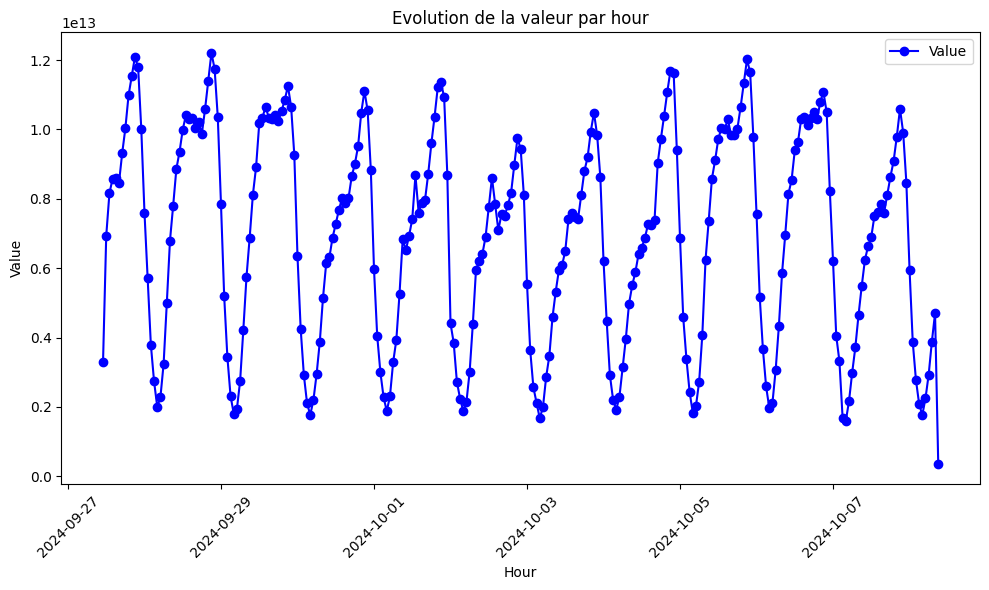

In [5]:
#  Afficher les valeurs initiale groupee par heur 
# ---------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# Lire le fichier CSV dans un DataFrame
df = pd.read_csv('grouped_values_by_hour.csv')

# Convertir la colonne 'date' en type datetime
df['hour'] = pd.to_datetime(df['hour'])

# Créer un graphique avec la date en abscisse et la valeur en ordonnée
plt.figure(figsize=(10, 6))
plt.plot(df['hour'], df['value'], marker='o', linestyle='-', color='b', label='Value')

# Ajouter des labels et un titre
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title('Evolution de la valeur par hour')

# Afficher les dates correctement sur l'axe X
plt.xticks(rotation=45)

# Afficher la légende
plt.legend()

# Ajuster la disposition pour éviter les chevauchements
plt.tight_layout()

# Enregistrer le graphique sous format PNG
plt.savefig('Grouper par hour.png', format='png')

# Afficher le graphique
plt.show()



Taux d'erreur (perte d'information) : 0.93%


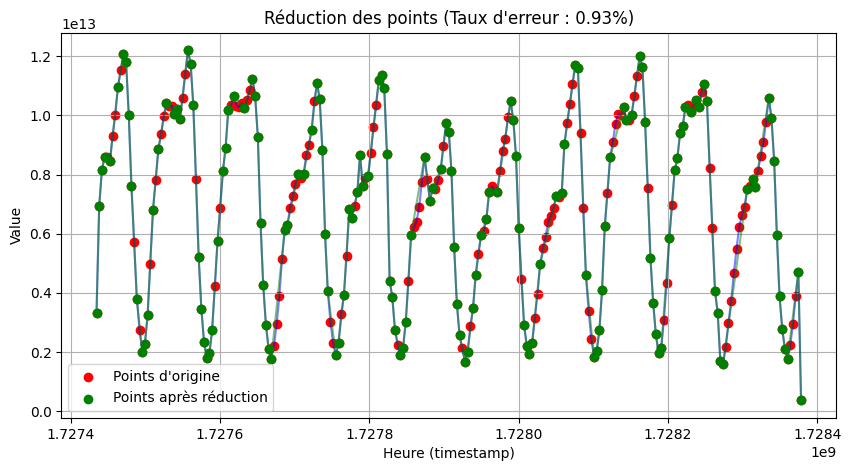

In [ ]:
# reduire le nombre des points 
# ------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def lire_points(fichier):
    """ Lit un fichier CSV contenant les colonnes 'hour' et 'value' et retourne un tableau NumPy """
    df = pd.read_csv(fichier, usecols=["hour", "value"], parse_dates=["hour"])  # Lire les colonnes nécessaires
    df["hour"] = df["hour"].astype("int64") // 10**9  # Convertir l'heure en secondes UNIX
    df["value"] = df["value"].astype(float)  # S'assurer que 'value' est bien numérique
    return df.values  # Convertir en tableau NumPy

def calculer_pente(point1, point2):
    """ Calcule la pente entre deux points (x1, y1) et (x2, y2). """
    return (point2[1] - point1[1]) / (point2[0] - point1[0])

def filtrer_points_par_plage_et_colinearite(points, epsilon, seuil_pente):
    """ Conserve seulement les points aux extrémités des plages successives proches 
        et élimine les points intermédiaires collinéaires.
    """
    reduced_points = [points[0]]  # Commence avec le premier point
    
    for i in range(1, len(points) - 1):
        # Si la différence en Y est inférieure à epsilon, c'est une plage
        if np.abs(points[i][1] - points[i - 1][1]) < epsilon and np.abs(points[i + 1][1] - points[i][1]) < epsilon:
            continue  # Ignorer les points intermédiaires dans la plage
        
        # Vérification de la colinéarité des trois points successifs
        pente1 = calculer_pente(points[i - 1], points[i])
        pente2 = calculer_pente(points[i], points[i + 1])
        
        if np.abs(pente1 - pente2) < seuil_pente:  # Si les pentes sont proches, points collinéaires
            continue  # Ignorer le point intermédiaire
        
        # Ajouter le point actuel
        reduced_points.append(points[i])
    
    # Ajouter le dernier point
    reduced_points.append(points[-1])
    
    return np.array(reduced_points)

def calculer_taux_erreur(points_originaux, points_reduits):
    """ Calcule le taux d'erreur entre les points d'origine et les points réduits en interpolant les valeurs manquantes. """
    # Interpolation linéaire sur les points réduits
    interpolation = interp1d(points_reduits[:, 0], points_reduits[:, 1], kind='linear', fill_value="extrapolate")
    
    # Estimation des Y pour les X des points d'origine
    y_interpoles = interpolation(points_originaux[:, 0])
    
    # Calcul du taux d'erreur basé sur la différence absolue normalisée
    erreur_absolue = np.abs(points_originaux[:, 1] - y_interpoles)
    erreur_totale = np.sum(erreur_absolue)
    somme_y_original = np.sum(points_originaux[:, 1])
    
    taux_erreur = (erreur_totale / somme_y_original) * 100  # En pourcentage
    return taux_erreur

# Nom des fichiers
fichier_points = "grouped_values_by_hour.csv"  # Fichier CSV en entrée
fichier_reduit = "points_reduits_by_hour.txt"  # Fichier CSV en sortie

# Lecture des points
points = lire_points(fichier_points)

# Application de la réduction avec un seuil donné
epsilon = 1e8  # Seuil pour la différence en Y
seuil_pente = 1e8  # Seuil pour la différence de pente
reduced_points = filtrer_points_par_plage_et_colinearite(points, epsilon, seuil_pente)

# Enregistrement des points réduits sous format CSV
pd.DataFrame(reduced_points, columns=['hour', 'value']).to_csv(fichier_reduit, index=False)

# Calcul du taux d'erreur
taux_erreur = calculer_taux_erreur(points, reduced_points)
print(f"Taux d'erreur (perte d'information) : {taux_erreur:.2f}%")

# Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(points[:, 0], points[:, 1], color='r', label="Points d'origine")
plt.plot(points[:, 0], points[:, 1], 'b-', alpha=0.5)  # Relie les points d'origine
plt.scatter(reduced_points[:, 0], reduced_points[:, 1], color='g', label="Points après réduction", zorder=3)
plt.plot(reduced_points[:, 0], reduced_points[:, 1], 'g-', alpha=0.5)  # Relie les points réduits
plt.legend()
plt.xlabel("Heure (timestamp)")
plt.ylabel("Value")
plt.title(f"Réduction des points (Taux d'erreur : {taux_erreur:.2f}%)")
plt.grid(True)
plt.show()
